# Deep Learning Assignment 4: CNNs for Face Identification 

We will perform face identification using a subset of the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/). Face identification is a multi-class calssification problem where we have training/testing images for a set of subjects (classes). In 2014, researchers were able to surpass human accuracy in facial identification tasks using CNN models (along with advanced deep learning techniques)! 

We will observe the performance of a traditional face identification method, [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface). We will then build a CNN model in order to surpass the accuracy of the traditional Eigenfaces technique. In the process, we will learn about the great power of CNNs!

### Requirements

1. Python 3.6
2. `pip install numpy`
3. `pip install sklearn`
4. `pip install matplotlib`
5. `pip install tensorflow==2.0.0`


### Rubric

1. Complete the sample CNN as specified by the comments (2 pts.)
2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different (3 pts.)
3. Build a fourth CNN model which achieves >70% test accuracy (3 pts.)
4. Display a correctly identified image and a training image corresponding to the correct training subject (1 pts.)
5. Display a incorrectly identified image and a training image corresponding to the correct training subject (1 pts.)


In [ ]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 70kB/s 
     |████████████████████████████████| 3.8MB 45.9MB/s 
     |████████████████████████████████| 450kB 44.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=e818163d0771f619d10ce014872161a518d1d2fcdb97275a43b159747604366f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully u

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

Let's start by downloading and setting up a subset of the aligned and segmented version of the LFW dataset. We will only get subjects with at least 20 corresponding images. We will also get the grayscale versions of the images. This may take a few minutes . . .

In [ ]:
data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=False, return_X_y=True)
# normalize pixel values to [0,1]
data_x = data_x / 255.

The downloaded `data_x` will be the flattened vector representation of the images. 

We will reshape the vector respresentations back into the original grayscale images and store the images back in `data_x`.

In [ ]:
num_subjects = np.unique(data_y).shape[0]
print("Number of subjects: {}".format(np.unique(data_y).shape[0]))
print("Number of images: {}\n".format(data_y.shape[0]))

# image_x will contain the original grayscale images 
data_x = np.copy(data_x.reshape((data_x.shape[0], 62, 47, 1)))

print("data_x shape: {}".format(data_x.shape))
print("data_y shape: {}".format(data_y.shape))

Number of subjects: 62
Number of images: 3023

data_x shape: (3023, 62, 47, 1)
data_y shape: (3023,)


As we can see, the dataset is made up of `3023` images of `62` subjects (or classes). 

Each image is a `62x47x1`-dimensional matrix containing 8-bit (0-255) grayscale pixel values.

Let's visualize a few of the grayscale images.

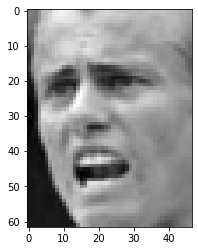

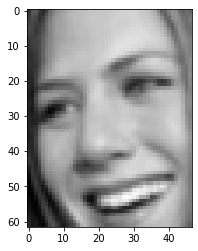

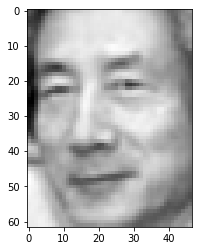

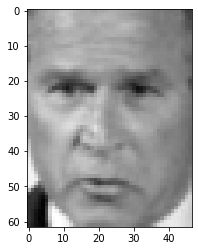

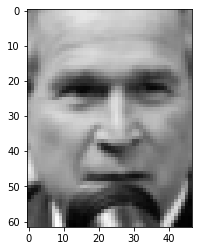

In [ ]:
np.random.seed(42)
for i in range(5):
    rnd_idx = np.random.choice(data_y.shape[0])
    rnd_img = data_x[rnd_idx]
    plt.figure()
    plt.imshow(rnd_img[:, :, 0], cmap="gray")

Now, let's split the dataset into train and test sets so we can perform face identification!

We will perform a `90/10` stratified split. This means that `90%` of each subject's images are placed in the train set, while the remaining `10%` of each subject's images are placed into the test set. 

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (2720, 62, 47, 1)
train_y shape: (2720,)

test_x shape: (303, 62, 47, 1)
test_y shape: (303,)


### Eigenfaces Overview

Eigenfaces is a face identification technique proposed in 1987. It was a very popular algorithm through the 1990's and is still used today as a baseline algorithm when gauging the performance of proposed face identification techniques. Eigenfaces is used to extract features from facial images. Such facial features are more useful in identification tasks than the corresponding oringinal images. The facial features can then be used for identification by being classified by a multi-class classifier, such a logistic regression model. 

### Eigenfaces Details

Eigenfaces is a Principcal Componet Analysis (PCA)-based dimensionality-reduction technique. Eigenfaces deals with the flattened vector representations of the face images. 

We give the vector representation of the training images as input to the algorithm. The output of the algoirthm is a set of Eigenfaces (vectors) which we can use to project vector representations of images into a lower-dimensional space which (hopefully) encode important facial features. 

Since the lower-dimensional space captures important facial features, Eigenfaces is used as a feature extraction technique. Given a facial image, we can reshape the image into a vector. Using the Eigenfaces, we reduce the dimensionality of the original vector into a vector which is more useful in identifying its corresponging subject. Therefore, we will use the Eigenfaces to extract facial features. Then, we will use a simple logistic regression classifier to classify the resulting facial features.

Let's start by flattening the training facial images. Then we will continue by computing the Eigenfaces which capture `95%` of the variance of the original dataset.

In [ ]:
# flatten images 
train_vector_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2])) 
test_vector_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2])) 

# retrieve eigenfaces
pca = PCA(n_components=0.95, random_state=42)
pca.fit(train_vector_x)
eigenfaces = pca.components_

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Eigenfaces shape: {}".format(eigenfaces.shape))

Training vectors shape: (2720, 2914)
Eigenfaces shape: (173, 2914)


As we see, if we flatten the training images to gather their vector representations, we recieve `2720` vectors of size `2914`. We also see that we have found `173` Eigenfaces vectors of size `2914`.

If we reshape the set of Eigenfaces to the shape of the original images, they reveal intesting ghost faces (i.e. "Eigenfaces").

Let's view the first `10` Eigenfaces.

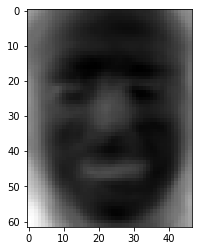

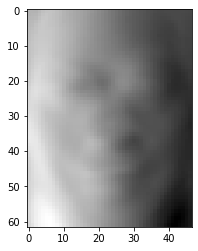

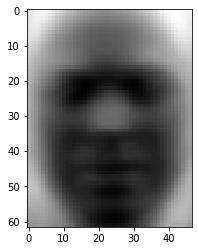

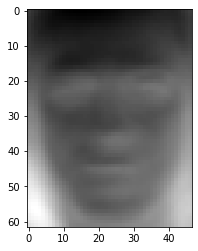

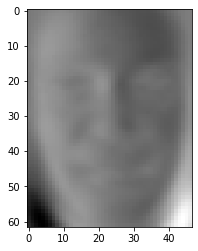

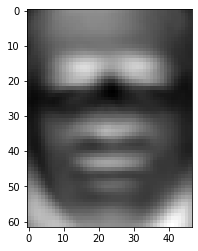

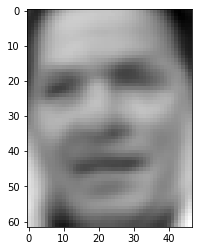

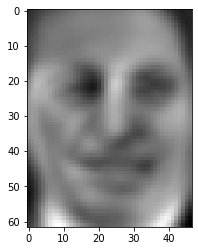

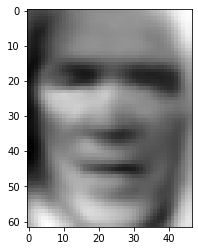

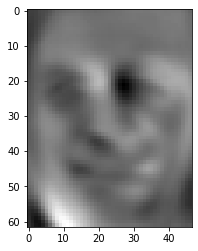

In [ ]:
for i in range(10):
    eigenface = eigenfaces[i].reshape((train_x.shape[1], train_x.shape[2]))
    plt.figure()
    plt.imshow(eigenface, cmap="gray")

Spooky!

Now, let's use the Eigenfaces to extract facial features from the training and test set vectors. Since we have `173` Eigenfaces, we will reduce the dimensionality of the `2914`-dimensional train/test vectors to `173`-dimensional train/test feature vectors.

In [ ]:
train_features_x = np.dot(train_vector_x, eigenfaces.T)
test_features_x = np.dot(test_vector_x, eigenfaces.T)

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Training features shape: {}".format(train_features_x.shape))
print("Testing vectors shape: {}".format(test_vector_x.shape))
print("Testing features shape: {}".format(test_features_x.shape))

Training vectors shape: (2720, 2914)
Training features shape: (2720, 173)
Testing vectors shape: (303, 2914)
Testing features shape: (303, 173)


Great! Now that we have extracted facial features from the train and testing set, let's perform facial identification using a simple logistic regression model!

In [ ]:
# specify the input size of the feature vectors
features = Input((train_features_x.shape[1],))
# a single fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(features)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
logistic_regression = Model(inputs=features, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
logistic_regression.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(logistic_regression.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 173)]             0         
_________________________________________________________________
dense (Dense)                (None, 62)                10788     
_________________________________________________________________
activation (Activation)      (None, 62)                0         
Total params: 10,788
Trainable params: 10,788
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model, verbose set to 0 to supress output, wait a moment for training to complete
logistic_regression.fit(train_features_x, train_y, validation_data=(test_features_x, test_y), class_weight=class_weights, epochs=75, batch_size=128, verbose=0)

# evaluate model, get train/test accuracy
train_eig_pred = np.argmax(logistic_regression.predict(train_features_x), axis=1)
test_eig_pred = np.argmax(logistic_regression.predict(test_features_x), axis=1)
print("\nTraining accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))


Training accuracy using Eigenfaces and logistic regression model: 0.8823529411764706
Testing accuracy using Eigenfaces and logistic regression model: 0.6171617161716172


# Your turn!

### Sample CNN Model
The Eigenfaces and logistic regression model doesn't perform that well on the unseen test set. Let's see how a simple CNN model compares.

Rather than dealing with vectors, we will begin working with the grayscale images directly. 

Remember that a CNN learns convolution filters which extract the most useful features. Then, a small neural network at the end of the CNN architecture performs the multi-class classification. Therefore, the CNN will make things less complex for us as the CNN will learn to perform both feature extraction and classification! 

<b> Complete the section below</b>

In [ ]:
# COMPLETE THE CODE ACCORDING TO THE COMMENTS
# specify the input size of the images
images = Input((train_x.shape[1], train_x.shape[2], 1,))
# a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
x = Conv2D(32, kernel_size=(9,9),padding='same',strides=1, activation='relu')(images)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D(pool_size=(2, 2))(x)
# another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
x = Conv2D(64, kernel_size=(11,11),padding='same',strides=1,activation='relu')(x)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D(pool_size=(2, 2))(x)
# flatten extracted features to form feature vector
x = Flatten()(x)
# a drop out layer for regularization (25% probability)
x = Dropout(0.25)(x)
# first fully-connected layer to map the features to vectors of size 256
x = Dense(units = 256, activation = 'relu')(x)
# anoter drop out layer for regularization (25% probability)
x = Dropout(0.25)(x)
# a second fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(x)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
sample_cnn = Model(inputs=images, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
sample_cnn.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(sample_cnn.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62, 47, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 47, 32)        2624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 23, 64)        247872    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10560)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10560)             0   

In [ ]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y), 
               class_weight=class_weights, 
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(sample_cnn.predict(train_x), axis=1)
test_pred = np.argmax(sample_cnn.predict(test_x), axis=1)
print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))

print("The sample CNN model beat the Eigenfaces and logistic regression model! :)")
print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Train on 2720 samples, validate on 303 samples
Epoch 1/15
2720/2720 [==============================] - 93s 34ms/sample - loss: 3.8152 - acc: 0.1397 - val_loss: 3.7093 - val_acc: 0.1485
Epoch 2/15
2720/2720 [==============================] - 92s 34ms/sample - loss: 3.7227 - acc: 0.1776 - val_loss: 3.6895 - val_acc: 0.1485
Epoch 3/15
2720/2720 [==============================] - 95s 35ms/sample - loss: 3.6762 - acc: 0.1772 - val_loss: 3.6313 - val_acc: 0.1485
Epoch 4/15
2720/2720 [==============================] - 92s 34ms/sample - loss: 3.5501 - acc: 0.1813 - val_loss: 3.4189 - val_acc: 0.1518
Epoch 5/15
2720/2720 [==============================] - 95s 35ms/sample - loss: 3.1660 - acc: 0.2415 - val_loss: 2.9289 - val_acc: 0.2772
Epoch 6/15
2720/2720 [==============================] - 93s 34ms/sample - loss: 2.6105 - acc: 0.3404 - val_loss: 2.3905 - val_acc: 0.4257
Epoch 7/15
2720/2720 [==============================] - 92s 34ms/sample - loss: 2.0955 - acc: 0.4566 - val_loss: 2.0164 - val

## More tasks

2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different 
3. Build a fourth CNN model which achieves >70% test accuracy 
4. Display a correctly identified image and a training image corresponding to the correct training subject 
5. Display a incorrectly identified image and a training image corresponding to the correct training subject 

In [ ]:
model1 = Conv2D(32, (3, 3), activation = 'relu')(images)
model1 = MaxPool2D(pool_size = (2, 2))(model1)
model1 = Conv2D(64, (3, 3), activation = 'relu')(images)
model1 = MaxPool2D(pool_size = (2, 2))(model1)
model1 = Flatten()(model1)
model1 = Dense(units = 128, activation = 'relu')(model1)
model1 = Dense(units = 64, activation = 'relu')(model1)
model1 = Dense(num_subjects)(model1)
predictions = Activation("softmax")(model1)

model1 = Model(inputs=images, outputs=predictions)

model1.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

print(model1.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 62, 47, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 22, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 42240)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               5406848   
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 62)                403

In [ ]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model1.fit(train_x, train_y, validation_data=(test_x, test_y), 
               class_weight=class_weights, 
               epochs=30, batch_size=32, verbose=0)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model1.predict(train_x), axis=1)
test_pred = np.argmax(model1.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model1: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model1: {}\n".format(accuracy_score(test_y, test_pred)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))


Training accuracy using CNN model1: 1.0
Testing accuracy using CNN model1: 0.6270627062706271

Training accuracy using Eigenfaces and logistic regression model: 0.8823529411764706
Testing accuracy using Eigenfaces and logistic regression model: 0.6171617161716172


In [ ]:
model2 = Conv2D(32, (3, 3), activation = 'relu')(images)
model2 = MaxPool2D(pool_size = (2, 2))(model2)
model2 = Conv2D(64, (5, 5), activation = 'relu')(images)
model2 = MaxPool2D(pool_size = (2, 2))(model2)
model2 = Flatten()(model2)
model2 = Dense(units = 256, activation = 'relu')(model2)
model2 = Dropout(0.50)(model2)
model2 = Dense(num_subjects)(model2)
predictions = Activation("softmax")(model2)

model2 = Model(inputs=images, outputs=predictions)

model2.compile(optimizer=RMSprop(), loss="sparse_categorical_crossentropy", metrics=["acc"])

print(model2.summary())

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 62, 47, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 58, 43, 64)        1664      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 29, 21, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 38976)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               9978112   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 62)                159

In [ ]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model2.fit(train_x, train_y, validation_data=(test_x, test_y), 
               class_weight=class_weights, 
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model2.predict(train_x), axis=1)
test_pred = np.argmax(model2.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model2: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model2: {}\n".format(accuracy_score(test_y, test_pred)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Train on 2720 samples, validate on 303 samples
Epoch 1/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 4.3020 - acc: 0.1452 - val_loss: 3.8219 - val_acc: 0.1485
Epoch 2/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 3.5809 - acc: 0.1908 - val_loss: 3.6512 - val_acc: 0.1980
Epoch 3/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 3.2180 - acc: 0.2562 - val_loss: 2.9989 - val_acc: 0.2937
Epoch 4/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 2.8487 - acc: 0.3169 - val_loss: 2.7718 - val_acc: 0.3036
Epoch 5/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 2.5008 - acc: 0.3835 - val_loss: 2.4838 - val_acc: 0.4290
Epoch 6/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 2.2307 - acc: 0.4426 - val_loss: 2.1995 - val_acc: 0.4818
Epoch 7/15
2720/2720 [==============================] - 14s 5ms/sample - loss: 1.9463 - acc: 0.5066 - val_loss: 2.0670 - val_acc: 0

In [ ]:
model3 = Conv2D(32, (3, 3), activation = 'relu')(images)
model3 = MaxPool2D(pool_size = (2, 2))(model3)
model3 = Conv2D(64, (3, 3), activation = 'relu')(images)
model3 = MaxPool2D(pool_size = (2, 2))(model3)
model3 = Flatten()(model3)
model3 = Dense(units = 1024, activation = 'relu')(model3)
model3 = Dropout(0.20)(model3)
model3 = BatchNormalization(momentum=0.9)(model3)
model3 = Dense(units = 512, activation = 'relu')(model3)
model3 = Dropout(0.20)(model3)
model3 = BatchNormalization(momentum=0.9)(model3)
model3 = Dense(num_subjects)(model3)
predictions = Activation("softmax")(model3)

model3 = Model(inputs=images, outputs=predictions)

model3.compile(optimizer=RMSprop(), loss="sparse_categorical_crossentropy", metrics=["acc"])

print(model3.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62, 47, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 22, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 42240)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              43254784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096

In [ ]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model3.fit(train_x, train_y, validation_data=(test_x, test_y), 
               class_weight=class_weights, 
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model3.predict(train_x), axis=1)
test_pred = np.argmax(model3.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model3: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model3: {}\n".format(accuracy_score(test_y, test_pred)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Train on 2720 samples, validate on 303 samples
Epoch 1/15
2720/2720 [==============================] - 36s 13ms/sample - loss: 3.9280 - acc: 0.1632 - val_loss: 3.9265 - val_acc: 0.0957
Epoch 2/15
2720/2720 [==============================] - 34s 13ms/sample - loss: 1.8789 - acc: 0.5441 - val_loss: 2.0495 - val_acc: 0.5281
Epoch 3/15
2720/2720 [==============================] - 34s 13ms/sample - loss: 0.9201 - acc: 0.7783 - val_loss: 1.7124 - val_acc: 0.6172
Epoch 4/15
2720/2720 [==============================] - 34s 13ms/sample - loss: 0.4291 - acc: 0.9007 - val_loss: 2.0029 - val_acc: 0.5578
Epoch 5/15
2720/2720 [==============================] - 36s 13ms/sample - loss: 0.2302 - acc: 0.9485 - val_loss: 2.2525 - val_acc: 0.5050
Epoch 6/15
2720/2720 [==============================] - 34s 13ms/sample - loss: 0.1511 - acc: 0.9684 - val_loss: 1.9058 - val_acc: 0.5809
Epoch 7/15
2720/2720 [==============================] - 34s 13ms/sample - loss: 0.0923 - acc: 0.9853 - val_loss: 1.8622 - val

In [ ]:
model4 = Conv2D(32, (3, 3), activation = 'relu')(images)
model4 = MaxPool2D(pool_size = (2, 2))(model4)
model4 = Conv2D(64, (3, 3), activation = 'relu')(images)
model4 = MaxPool2D(pool_size = (2, 2))(model4)
model4 = Conv2D(128, (3, 3), activation = 'relu')(images)
model4 = MaxPool2D(pool_size = (2, 2))(model4)
model4 = Flatten()(model4)
model4 = Dense(units = 1024, activation = 'relu')(model4)
model4 = Dropout(0.20)(model4)
model4 = BatchNormalization(momentum=0.9)(model4)
model4 = Dense(units = 512, activation = 'relu')(model4)
model4 = Dropout(0.20)(model4)
# model4 = BatchNormalization(momentum=0.9)(model4)
model4 = Dense(num_subjects)(model4)
predictions = Activation("softmax")(model4)

model4 = Model(inputs=images, outputs=predictions)

model4.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

print(model4.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62, 47, 1)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 60, 45, 128)       1280      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 30, 22, 128)       0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 84480)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              86508544  
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)              409

In [ ]:
# train model
model4.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model4.predict(train_x), axis=1)
test_pred = np.argmax(model4.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model4: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model4: {}\n".format(accuracy_score(test_y, test_pred)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Train on 2720 samples, validate on 303 samples
Epoch 1/10
2720/2720 [==============================] - 60s 22ms/sample - loss: 3.7184 - acc: 0.1658 - val_loss: 6.6953 - val_acc: 0.0165
Epoch 2/10
2720/2720 [==============================] - 58s 21ms/sample - loss: 2.3427 - acc: 0.4357 - val_loss: 2.3221 - val_acc: 0.5314
Epoch 3/10
2720/2720 [==============================] - 58s 21ms/sample - loss: 1.0363 - acc: 0.7529 - val_loss: 1.4563 - val_acc: 0.6172
Epoch 4/10
2720/2720 [==============================] - 58s 21ms/sample - loss: 0.3705 - acc: 0.9206 - val_loss: 1.3033 - val_acc: 0.6634
Epoch 5/10
2720/2720 [==============================] - 58s 21ms/sample - loss: 0.1450 - acc: 0.9713 - val_loss: 1.3580 - val_acc: 0.6898
Epoch 6/10
2720/2720 [==============================] - 58s 21ms/sample - loss: 0.0676 - acc: 0.9901 - val_loss: 1.3136 - val_acc: 0.6964
Epoch 7/10
2720/2720 [==============================] - 59s 22ms/sample - loss: 0.0273 - acc: 0.9982 - val_loss: 1.3382 - val

### Rubric

1. Complete the sample CNN as specified by the comments (2 pts.)
2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different (3 pts.)
3. Build a fourth CNN model which achieves >70% test accuracy (3 pts.)
4. Display a correctly identified image and a training image corresponding to the correct training subject (1 pts.)
5. Display a incorrectly identified image and a training image corresponding to the correct training subject (1 pts.)

Feel free to use the code above to get started on your own models!

Predicted Label: 37, True True: 37


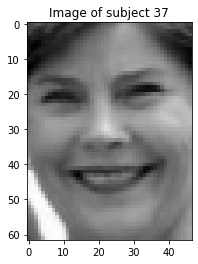

In [ ]:
# A correctly identified image
n = 0
image = np.expand_dims(test_x[n], axis=0)
correct_pred = np.argmax(model4.predict(image))
true_pred = test_y[n]
print(f'Predicted Label: {correct_pred}, True True: {true_pred}')
plt.figure()
plt.title(f'Image of subject {true_pred}')
plt.imshow(train_x[list(train_y).index(true_pred)][:, :, 0], cmap="gray");

Predicted Label: 45, True Label: 29


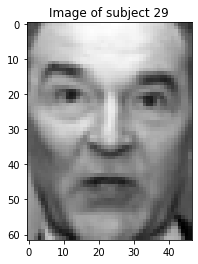

In [ ]:
# An incorrectly identified image
n = 5
image = np.expand_dims(test_x[n], axis=0)
correct_pred = np.argmax(model4.predict(image))
true_pred = test_y[n]
print(f'Predicted Label: {correct_pred}, True Label: {true_pred}')
plt.figure()
plt.title(f'Image of subject {true_pred}')
plt.imshow(train_x[list(train_y).index(true_pred)][:, :, 0], cmap="gray");